## Feature set 1

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import librosa
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
import time
from keras.callbacks import EarlyStopping

from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout,merge,Activation

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

Using TensorFlow backend.


#### Extracting data from csv files into numpy arrays

In [2]:
#extracting data from csv files into numpy arrays
from numpy import genfromtxt
files_data=np.array(['fold_data_1.csv','fold_data_2.csv','fold_data_3.csv','fold_data_4.csv','fold_data_5.csv',
                'fold_data_6.csv','fold_data_7.csv','fold_data_8.csv','fold_data_9.csv','fold_data_10.csv'])
X_folds= np.array([genfromtxt(file,delimiter=',') for file in files_data])

files_label=(['fold_labels_1.csv','fold_labels_2.csv','fold_labels_3.csv','fold_labels_4.csv','fold_labels_5.csv',
                'fold_labels_6.csv','fold_labels_7.csv','fold_labels_8.csv','fold_labels_9.csv','fold_labels_10.csv'])
Y_folds= np.array([genfromtxt(file,delimiter=',') for file in files_label])

In [3]:
def data_processor_cnn(X_fold,Y_fold):
    X_fold_processor_cnn = [0]*10
    Y_fold_processor_cnn = [0]*10
    Y_fold_processor_cnn=([to_categorical(Y_fold, num_classes=10) for Y_fold in Y_fold])
    for i in range(0, len(X_fold)):
        X_fold_processor_cnn[i]=np.reshape(X_fold[i],(X_fold[i].shape[0], 60, 4, 1))
    return X_fold_processor_cnn,Y_fold_processor_cnn

In [4]:
def data_processor_basic_nn(X_fold,Y_fold):
    X_fold_basic_nn = [0]*10
    Y_fold_basic_nn = [0]*10
    for i in range(0, len(Y_fold)):
        Y_fold_basic_nn[i]=np.reshape(Y_fold[i],(Y_fold[i].shape[0], 1))
    for i in range(0, len(X_fold)):
        X_fold_basic_nn[i]=np.reshape(X_fold[i],(X_fold[i].shape[0], 60, 4))
    return X_fold_basic_nn,Y_fold_basic_nn

In [5]:
def data_processor_log_reg(X_fold,Y_fold):
    X_fold_log_reg = [0]*10
    Y_fold_log_reg = [0]*10
    for i in range(0, len(Y_fold)):
        Y_fold_log_reg[i]=np.reshape(Y_fold[i],(Y_fold[i].shape[0], 1))
    for i in range(0, len(X_fold)):
        X_fold_log_reg[i]=np.reshape(X_fold[i],(X_fold[i].shape[0], 240))
    return X_fold_log_reg,Y_fold_log_reg

In [6]:
Data_cnn=data_processor_cnn(X_folds,Y_folds)
X_folds_10=Data_cnn[0]
Y_folds_10=Data_cnn[1]

In [7]:
Data_nn=data_processor_basic_nn(X_folds,Y_folds)
X_folds_1=Data_nn[0]
Y_folds_1=Data_nn[1]

In [8]:
Data_Linear=data_processor_log_reg(X_folds,Y_folds)
X_folds_2=Data_Linear[0]
Y_folds_2=Data_Linear[1]

##### shapes of data

In [9]:
for i in range((10)):
    print("X_data",i+1,"=",np.shape(X_folds_10[i]))
    print("Y_data",i+1,"=",np.shape(Y_folds_10[i]))
    
for i in range((10)):
    print("X_data",i+1,"=",np.shape(X_folds_1[i]))
    print("Y_data",i+1,"=",np.shape(Y_folds_1[i]))

X_data 1 = (873, 60, 4, 1)
Y_data 1 = (873, 10)
X_data 2 = (888, 60, 4, 1)
Y_data 2 = (888, 10)
X_data 3 = (925, 60, 4, 1)
Y_data 3 = (925, 10)
X_data 4 = (990, 60, 4, 1)
Y_data 4 = (990, 10)
X_data 5 = (936, 60, 4, 1)
Y_data 5 = (936, 10)
X_data 6 = (823, 60, 4, 1)
Y_data 6 = (823, 10)
X_data 7 = (838, 60, 4, 1)
Y_data 7 = (838, 10)
X_data 8 = (806, 60, 4, 1)
Y_data 8 = (806, 10)
X_data 9 = (816, 60, 4, 1)
Y_data 9 = (816, 10)
X_data 10 = (837, 60, 4, 1)
Y_data 10 = (837, 10)
X_data 1 = (873, 60, 4)
Y_data 1 = (873, 1)
X_data 2 = (888, 60, 4)
Y_data 2 = (888, 1)
X_data 3 = (925, 60, 4)
Y_data 3 = (925, 1)
X_data 4 = (990, 60, 4)
Y_data 4 = (990, 1)
X_data 5 = (936, 60, 4)
Y_data 5 = (936, 1)
X_data 6 = (823, 60, 4)
Y_data 6 = (823, 1)
X_data 7 = (838, 60, 4)
Y_data 7 = (838, 1)
X_data 8 = (806, 60, 4)
Y_data 8 = (806, 1)
X_data 9 = (816, 60, 4)
Y_data 9 = (816, 1)
X_data 10 = (837, 60, 4)
Y_data 10 = (837, 1)


# Defining Functions
## Simple nn function

In [10]:

def Model_run_nn(model_history,model,X_folds,Y_folds,Accuracy_array,accuracy_total,end_array,Epoch_array_accuracy,Loss_array,
             Fold_accuracy,Val_accuracy_array,Val_Loss_array, Confusion_Matrix_array, 
             Metrics_f1, Metrics_precision, Metrics_recall, Metrics_accuracy):
   
    fold=0
    for i in range(10):
        start = time.time()
        fold+=1
        print(f"\nFold #{fold}\n- - - - - - - - - - - - - - - - - - - -")

        x_train = np.vstack([X_folds[j] for j in range(0, len(Y_folds)) if i!=j])
        y_train = np.vstack([Y_folds[j] for j in range(0, len(Y_folds)) if i!=j])
        x_test = np.vstack([X_folds[j] for j in range(0, len(Y_folds)) if i==j])
        y_test = np.vstack([Y_folds[j] for j in range(0, len(Y_folds)) if i==j])
        print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
    
        model_history = model.fit(x_train,y_train,batch_size=Batch_size,epochs=Epoch_number,validation_data=(x_test,y_test)
                                  ,verbose=0)
        
        model_evaluation = model.evaluate(x_test, y_test, verbose = 0)
        score=model_evaluation[1]
        accuracy_score.append(score)
        
        # Generate confusion matrix
        y_pred = model.predict_classes(x_test)
        cm = sklearn.metrics.confusion_matrix(y_test, y_pred)
        Confusion_Matrix_array.append(cm)
        
        # metrics
        f1 = sklearn.metrics.f1_score(y_test, y_pred, average='weighted')
        precision = sklearn.metrics.precision_score(y_test, y_pred, average='weighted')
        recall = sklearn.metrics.recall_score(y_test, y_pred, average='weighted')
        accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)
        
        Metrics_f1.append(f1)
        Metrics_precision.append(precision)
        Metrics_recall.append(recall)
        Metrics_accuracy.append(accuracy)
        
        accuracy=model_history.history['accuracy']
        accuracy_avg=np.mean(accuracy)
        
        Fold_accuracy.append(accuracy_avg)
        print(f"Accuracy of Fold {fold} is {accuracy_avg}")
        end = time.time()
        print("Time to train Fold", fold,":",round(((end)- (start)),4),"seconds.")
        end_array.append(round(((end)- (start)),4))
        
    
        Epoch_array=model_history.history['accuracy']
        Epoch_array_accuracy.append(Epoch_array)
        loss=model_history.history['loss']
        Loss_array.append(loss)
    
        Epoch_val_array=model_history.history['val_accuracy']
        Val_accuracy_array.append(Epoch_val_array)
    
        loss_val=model_history.history['val_loss']
        Val_Loss_array.append(loss_val)
    
    Avg_Accuracy=np.mean(Fold_accuracy)       
    Time=sum(end_array)
    print("\n - - - - - - - - - - - - - - -\nThe average accuracy of the model:",(Avg_Accuracy))
    print("The time taken to run model:",Time)
    return Avg_Accuracy,Time

In [11]:
def Model_run_nn_es(model_history,model,X_folds,Y_folds,Accuracy_array,accuracy_total,end_array,Epoch_array_accuracy,Loss_array,
             Fold_accuracy,Val_accuracy_array,Val_Loss_array, Confusion_Matrix_array,
             Metrics_f1, Metrics_precision, Metrics_recall, Metrics_accuracy):
    
    for i in range(0, len(X_folds)):
        X_folds[i]=np.reshape(X_folds[i],(X_folds[i].shape[0], 60, 4, 1))
    fold=0
    for i in range(10):
        start = time.time()
        fold+=1
        print(f"\nFold #{fold}\n- - - - - - - - - - - - - - - - - - - -")

        x_train = np.vstack([X_folds[j] for j in range(0, len(Y_folds)) if i!=j])
        y_train = np.vstack([Y_folds[j] for j in range(0, len(Y_folds)) if i!=j])
        x_test = np.vstack([X_folds[j] for j in range(0, len(Y_folds)) if i==j])
        y_test = np.vstack([Y_folds[j] for j in range(0, len(Y_folds)) if i==j])
        print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
    
        model_history = model.fit(x_train,y_train,epochs=Epoch_number,validation_data=(x_test,y_test)
                                  ,verbose=0, callbacks=[early_stopping_cb])
        
        model_evaluation = model.evaluate(x_test, y_test, verbose = 0)
        score=model_evaluation[1]
        accuracy_score.append(score)
        
        # Generate confusion matrix
        y_pred = model.predict_classes(x_test)
        # Reverse categorical y_test (used in CNN)
        y_test_a = np.argmax(y_test, axis=1)
#         print(y_test_a)
        cm = sklearn.metrics.confusion_matrix(y_test_a, y_pred)
        Confusion_Matrix_array.append(cm)
        
        # metrics
        f1 = sklearn.metrics.f1_score(y_test_a, y_pred, average='weighted')
        precision = sklearn.metrics.precision_score(y_test_a, y_pred, average='weighted')
        recall = sklearn.metrics.recall_score(y_test_a, y_pred, average='weighted')
        accuracy = sklearn.metrics.accuracy_score(y_test_a, y_pred)
        
        Metrics_f1.append(f1)
        Metrics_precision.append(precision)
        Metrics_recall.append(recall)
        Metrics_accuracy.append(accuracy)
        
        accuracy=model_history.history['accuracy']
        accuracy_avg=np.mean(accuracy)
        
        Fold_accuracy.append(accuracy_avg)
        print(f"Accuracy of Fold {fold} is {accuracy_avg}")
        end = time.time()
        print("Time to train Fold", fold,":",round(((end)- (start)),4),"seconds.")
        end_array.append(round(((end)- (start)),4))
        
    
        Epoch_array=model_history.history['accuracy']
        Epoch_array_accuracy.append(Epoch_array)
        loss=model_history.history['loss']
        Loss_array.append(loss)
    
        Epoch_val_array=model_history.history['val_accuracy']
        Val_accuracy_array.append(Epoch_val_array)
    
        loss_val=model_history.history['val_loss']
        Val_Loss_array.append(loss_val)
    
    Avg_Accuracy=np.mean(Fold_accuracy)       
    Time=sum(end_array)
    print("\n - - - - - - - - - - - - - - -\nThe average accuracy of the model:",(Avg_Accuracy))
    print("The time taken to run model:",Time)
    return Avg_Accuracy,Time

In [12]:
def Model_run_nn_es_NO_EARLY_STOPPING(model_history,model,X_folds,Y_folds,Accuracy_array,accuracy_total,end_array,Epoch_array_accuracy,Loss_array,
             Fold_accuracy,Val_accuracy_array,Val_Loss_array, Confusion_Matrix_array,
             Metrics_f1, Metrics_precision, Metrics_recall, Metrics_accuracy):
    
    for i in range(0, len(X_folds)):
        X_folds[i]=np.reshape(X_folds[i],(X_folds[i].shape[0], 60, 4, 1))
    fold=0
    for i in range(10):
        start = time.time()
        fold+=1
        print(f"\nFold #{fold}\n- - - - - - - - - - - - - - - - - - - -")

        x_train = np.vstack([X_folds[j] for j in range(0, len(Y_folds)) if i!=j])
        y_train = np.vstack([Y_folds[j] for j in range(0, len(Y_folds)) if i!=j])
        x_test = np.vstack([X_folds[j] for j in range(0, len(Y_folds)) if i==j])
        y_test = np.vstack([Y_folds[j] for j in range(0, len(Y_folds)) if i==j])
        print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
    
        model_history = model.fit(x_train,y_train,epochs=Epoch_number,validation_data=(x_test,y_test)
                                  ,verbose=0)
        
        model_evaluation = model.evaluate(x_test, y_test, verbose = 0)
        score=model_evaluation[1]
        accuracy_score.append(score)
        
        # Generate confusion matrix
        y_pred = model.predict_classes(x_test)
        # Reverse categorical y_test (used in CNN)
        y_test_a = np.argmax(y_test, axis=1)
#         print(y_test_a)
        cm = sklearn.metrics.confusion_matrix(y_test_a, y_pred)
        Confusion_Matrix_array.append(cm)
        
        # metrics
        f1 = sklearn.metrics.f1_score(y_test_a, y_pred, average='weighted')
        precision = sklearn.metrics.precision_score(y_test_a, y_pred, average='weighted')
        recall = sklearn.metrics.recall_score(y_test_a, y_pred, average='weighted')
        accuracy = sklearn.metrics.accuracy_score(y_test_a, y_pred)
        
        Metrics_f1.append(f1)
        Metrics_precision.append(precision)
        Metrics_recall.append(recall)
        Metrics_accuracy.append(accuracy)
        
        accuracy=model_history.history['accuracy']
        accuracy_avg=np.mean(accuracy)
        
        Fold_accuracy.append(accuracy_avg)
        print(f"Accuracy of Fold {fold} is {accuracy_avg}")
        end = time.time()
        print("Time to train Fold", fold,":",round(((end)- (start)),4),"seconds.")
        end_array.append(round(((end)- (start)),4))
        
    
        Epoch_array=model_history.history['accuracy']
        Epoch_array_accuracy.append(Epoch_array)
        loss=model_history.history['loss']
        Loss_array.append(loss)
    
        Epoch_val_array=model_history.history['val_accuracy']
        Val_accuracy_array.append(Epoch_val_array)
    
        loss_val=model_history.history['val_loss']
        Val_Loss_array.append(loss_val)
    
    Avg_Accuracy=np.mean(Fold_accuracy)       
    Time=sum(end_array)
    print("\n - - - - - - - - - - - - - - -\nThe average accuracy of the model:",(Avg_Accuracy))
    print("The time taken to run model:",Time)
    return Avg_Accuracy,Time

### Graph function

In [13]:
def Graph_func(Epoch_number,Epoch_array_accuracy,Val_accuracy_array,Loss_array,val_loss_array):
    %matplotlib inline
    
    fig,ax1 = plt.subplots(1, 1, constrained_layout=True, subplot_kw=dict())
    fig.suptitle(f"Accuracy of each Epoch for each Fold")
    ax1.set_xlabel("Epoch number")
    ax1.set_ylabel("Accuracy")
    ax1.grid()
    for i in range(10):
        ax1.plot(Epoch_array_accuracy[i],label=('Fold',i+1))
        ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    
    fig,ax1 = plt.subplots(1, 1, constrained_layout=True, subplot_kw=dict())
    fig.suptitle(f"Accuracy of each Epoch for each Fold")
    ax1.set_xlabel("Epoch number")
    ax1.set_ylabel("Val Accuracy")
    ax1.grid()
    for i in range(10):
        ax1.plot(Val_accuracy_array[i],label=('Fold',i+1))
        ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    fig1,ax2 = plt.subplots(1, 1, constrained_layout=True, subplot_kw=dict())
    fig1.suptitle(f"Loss of each Epoch for each Fold")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Loss")
    ax2.grid()
    for i in range(10):
        ax2.plot(Loss_array[i],label=('Fold',i+1))
        ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))    
    
    fig1,ax2 = plt.subplots(1, 1, constrained_layout=True, subplot_kw=dict())
    fig1.suptitle(f"Val Loss of each Epoch for each Fold")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Val Loss")
    ax2.grid()
    for i in range(10):
        ax2.plot(val_loss_array[i],label=('Fold',i+1))
        ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))   

### Table function

In [14]:
def table_maker(Fold_accuracy,end_array,Avg_Accuracy,Time):
    data= {'Fold': ['1','2','3','4','5','6','7','8','9','10'],
           'Accuracy': [Fold_accuracy[0],Fold_accuracy[1],Fold_accuracy[2],Fold_accuracy[3],Fold_accuracy[4],
                    Fold_accuracy[5],Fold_accuracy[6],Fold_accuracy[7],Fold_accuracy[8],Fold_accuracy[9]],
           'Time Taken' :[end_array[0],end_array[1],end_array[2],end_array[3],end_array[4],end_array[5],end_array[6],end_array[7],
                end_array[8],end_array[9]]}
    df = pd.DataFrame(data, columns = ['Fold', 'Accuracy','Time Taken'])
    data_avg={'Average Accuracy':[Avg_Accuracy],'Total Time':[Time]}
    df_avg=pd.DataFrame(data_avg,columns=['Average Accuracy','Total Time'])
    print (df)
    print ("\n",df_avg)

### Average graph function

In [15]:
def Graph_Avg_maker(Fold_accuracy,Avg_Accuracy):
    %matplotlib inline
    Fold_iteration=np.linspace(1,10,num=10)
    fig, ax1 = plt.subplots(1, 1, constrained_layout=True, subplot_kw=dict())
    ax1.plot(Fold_iteration,Fold_accuracy,"gx")
    ax1.axhline(y=Avg_Accuracy,label='Average Accuracy')
    fig.suptitle(f"Results for Batch size of {Batch_size}\n and Epoch number of {Epoch_number}\n for Feature set 1")
    ax1.set_xlabel("Fold iteration")
    ax1.set_ylabel("Accuracy")
    ax1.grid()
    ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Confusion matrix function

In [16]:
import sklearn
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

def Confusion_matrix(x_test, y_test_a, model=None):

    if model == None:
        return 'Please pass a defined model to this function'
    
    # Create predictions
    try:
        y_test_pred = model.predict_classes(x_test)
    except:
        y_test_pred = model.predict(x_test)
    
    # Read file with the defined classes (should be available in every folder)
    classes = pd.read_csv("classes.csv")
    classes = classes['class'].tolist()
    
    # Create confusion matrix
    array = sklearn.metrics.confusion_matrix(y_test_a, y_test_pred)

    axis_labels = classes # labels for x and y axis

    # create seaborn heatmap with required labels
    plt.figure(figsize = (12, 10))
    sn.heatmap(array, annot=True, xticklabels=axis_labels, yticklabels=axis_labels)
    # fixing axis that are cut otherwise
    b, t = plt.ylim()
    b += 0.5
    t -= 0.5
    plt.ylim(b, t)
    plt.show()

In [17]:
def plot_confusion_matrix(cm):
    
    # Read file with the defined classes (should be available in every folder)
    classes = pd.read_csv("classes.csv")
    classes = classes['class'].tolist()
    
    # Read confusion matrix
    array = cm

    axis_labels = classes # labels for x and y axis

    # create seaborn heatmap with required labels
    plt.figure(figsize = (12, 10))
    sn.heatmap(array, annot=True, xticklabels=axis_labels, yticklabels=axis_labels)
    # fixing axis that are cut otherwise
    b, t = plt.ylim()
    b += 0.5
    t -= 0.5
    plt.ylim(b, t)
    plt.show()

In [18]:
def average_confusion_matrix(X):
    # Returns the average confusion matrix for the 10-fold cross-validation results
    avg_cm = (X[0]+X[1]+X[2]+X[3]+X[4]+X[5]+X[6]+X[7]+X[8]+X[9])
    return avg_cm

## Model 1

In [19]:
model=Sequential()
model.add(Flatten(input_shape=[60, 4]))
model.add(Dense(300, activation="relu"))   
model.add(Dense(100, activation="relu"))
model.add(Dense(10, activation="softmax"))
Model=model.compile(loss = "sparse_categorical_crossentropy", optimizer="adam", metrics = ["accuracy"])

In [20]:
Accuracy_array=[]
accuracy_total=0
end_array=[]
Epoch_array_accuracy=[]
Loss_array=[]
Fold_accuracy=[]
Val_accuracy_array=[]
Val_Loss_array_1=[]
Avg_Accuracy=[]
Time=[]
accuracy_score=[]
Confusion_Matrix_array = []
Metrics_f1 = []
Metrics_precision = []
Metrics_recall = []
Metrics_accuracy = []

Epoch_number=50
Batch_size=30

Model=Model_run_nn(Model,model,X_folds_1,Y_folds_1,Accuracy_array,
                   accuracy_total,end_array,Epoch_array_accuracy,Loss_array,
                   Fold_accuracy,Val_accuracy_array,Val_Loss_array_1, Confusion_Matrix_array,
                   Metrics_f1, Metrics_precision, Metrics_recall, Metrics_accuracy)

Avg_Accuracy=Model[0]
Time=Model[1]


Fold #1
- - - - - - - - - - - - - - - - - - - -
(7859, 60, 4) (7859, 1) (873, 60, 4) (873, 1)
Accuracy of Fold 1 is 0.6846087574958801
Time to train Fold 1 : 47.2897 seconds.

Fold #2
- - - - - - - - - - - - - - - - - - - -
(7844, 60, 4) (7844, 1) (888, 60, 4) (888, 1)
Accuracy of Fold 2 is 0.8394773006439209
Time to train Fold 2 : 50.6946 seconds.

Fold #3
- - - - - - - - - - - - - - - - - - - -
(7807, 60, 4) (7807, 1) (925, 60, 4) (925, 1)
Accuracy of Fold 3 is 0.878101646900177
Time to train Fold 3 : 47.2266 seconds.

Fold #4
- - - - - - - - - - - - - - - - - - - -
(7742, 60, 4) (7742, 1) (990, 60, 4) (990, 1)
Accuracy of Fold 4 is 0.8898993730545044
Time to train Fold 4 : 41.9965 seconds.

Fold #5
- - - - - - - - - - - - - - - - - - - -
(7796, 60, 4) (7796, 1) (936, 60, 4) (936, 1)
Accuracy of Fold 5 is 0.8954464197158813
Time to train Fold 5 : 26.6882 seconds.

Fold #6
- - - - - - - - - - - - - - - - - - - -
(7909, 60, 4) (7909, 1) (823, 60, 4) (823, 1)
Accuracy of Fold 6 is 0.90

In [21]:
print('Fold No, F-measure, Precision, Recall, Accuracy')
for i in range(10):
    print(f'{i+1}, {Metrics_f1[i]}, {Metrics_precision[i]}, {Metrics_recall[i]}, {Metrics_accuracy[i]}')
#     print(i + Metrics_f1 + ' , 'Metrics_precision + ' , 'Metrics_recall + ' , 'Metrics_accuracy)

Fold No, F-measure, Precision, Recall, Accuracy
1, 0.5620300407533415, 0.5953222955034254, 0.563573883161512, 0.563573883161512
2, 0.6491534827586608, 0.7050472378625692, 0.6418918918918919, 0.6418918918918919
3, 0.746827318887436, 0.8088921700609292, 0.7437837837837837, 0.7437837837837837
4, 0.8826523942758833, 0.9139162146808812, 0.8686868686868687, 0.8686868686868687
5, 0.8890498183238914, 0.9196123223297985, 0.8771367521367521, 0.8771367521367521
6, 0.8900715182392213, 0.9215540714327348, 0.8784933171324423, 0.8784933171324423
7, 0.8739084418046311, 0.9076888330436169, 0.8627684964200477, 0.8627684964200477
8, 0.7831369939744909, 0.8413646119389141, 0.7667493796526055, 0.7667493796526055
9, 0.866341272137206, 0.932978404461999, 0.8382352941176471, 0.8382352941176471
10, 0.9146516066302371, 0.9395378641472337, 0.9032258064516129, 0.9032258064516129


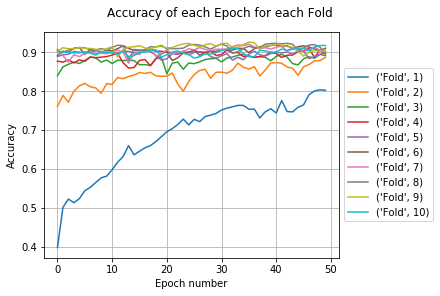

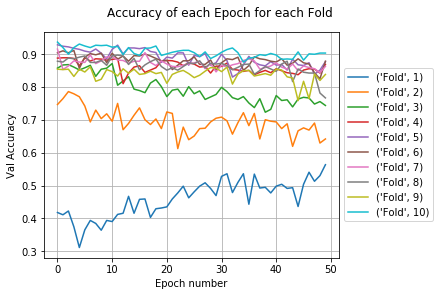

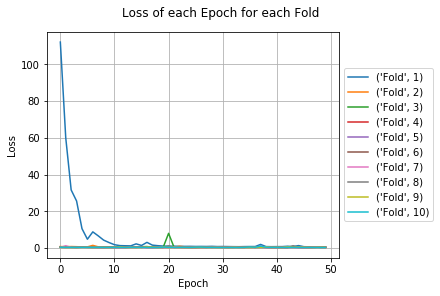

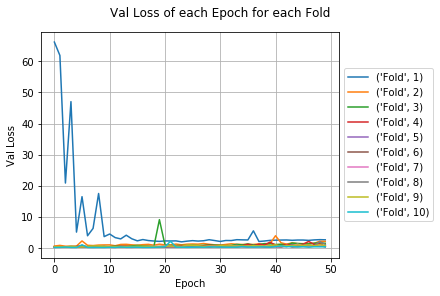

In [22]:
Graph_Epochs_model_1=Graph_func(Epoch_number,Epoch_array_accuracy,Val_accuracy_array,Loss_array,Val_Loss_array_1)

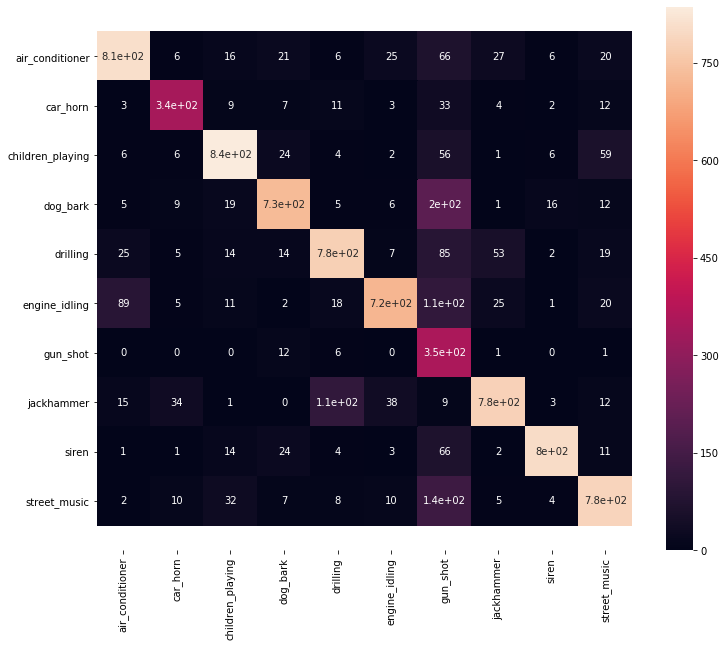

In [23]:
avg_cm = average_confusion_matrix(Confusion_Matrix_array)
plot_confusion_matrix(avg_cm)

In [24]:
Table_model_1=table_maker(Fold_accuracy,end_array,Avg_Accuracy,Time)

  Fold  Accuracy  Time Taken
0    1  0.684609     47.2897
1    2  0.839477     50.6946
2    3  0.878102     47.2266
3    4  0.889899     41.9965
4    5  0.895446     26.6882
5    6  0.905449     17.0929
6    7  0.903299     17.7785
7    8  0.911131     17.9307
8    9  0.911986     17.6864
9   10  0.900314     17.7348

    Average Accuracy  Total Time
0          0.871971    302.1189


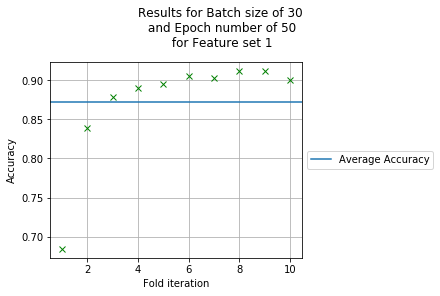

In [25]:
Graph_Avg_model_1=Graph_Avg_maker(Fold_accuracy,Avg_Accuracy)

### Model 1 no cross validation

In [26]:
for i in range(0, len(X_folds)):
    X_folds[i]=np.reshape(X_folds[i],(X_folds[i].shape[0], 60, 4))

X_train = np.vstack([X_folds[j] for j in range(0, len(Y_folds)-1)])
y_train = np.vstack([Y_folds_1[j] for j in range(0, len(Y_folds_1)-1)])
X_test = X_folds[9]
y_test = Y_folds[9]

Epoch_number=30

#compile model using accuracy to measure model performance
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#train the model
cnn_model_history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=Epoch_number)
score_model_1_no_cross=model.evaluate(X_test, y_test)
accuracy_model_1_no_cross = score_model_1_no_cross[1]
print(f"\nAccuracy of model 1 with no cross validation: {round(accuracy_model_1_no_cross,3)}")

Train on 7895 samples, validate on 837 samples
Epoch 1/30
7895/7895 [==============================] - ETA: 0s - loss: 0.1777 - accuracy: 0.90 - ETA: 0s - loss: 0.2163 - accuracy: 0.91 - ETA: 0s - loss: 0.2213 - accuracy: 0.91 - ETA: 0s - loss: 0.2297 - accuracy: 0.91 - ETA: 0s - loss: 0.2372 - accuracy: 0.91 - ETA: 0s - loss: 0.2561 - accuracy: 0.91 - ETA: 0s - loss: 0.2570 - accuracy: 0.91 - ETA: 0s - loss: 0.2595 - accuracy: 0.91 - 0s 53us/step - loss: 0.2612 - accuracy: 0.9141 - val_loss: 0.4614 - val_accuracy: 0.8984
Epoch 2/30
7895/7895 [==============================] - ETA: 0s - loss: 0.2819 - accuracy: 0.90 - ETA: 0s - loss: 0.2774 - accuracy: 0.90 - ETA: 0s - loss: 0.2984 - accuracy: 0.90 - ETA: 0s - loss: 0.2942 - accuracy: 0.90 - ETA: 0s - loss: 3.0165 - accuracy: 0.90 - ETA: 0s - loss: 2.4690 - accuracy: 0.90 - ETA: 0s - loss: 2.1288 - accuracy: 0.89 - ETA: 0s - loss: 1.8389 - accuracy: 0.89 - ETA: 0s - loss: 1.6399 - accuracy: 0.89 - 0s 56us/step - loss: 1.6040 - accuracy

## Model 2

In [27]:
#adding layers and forming the model_1
#forming model_1
model_2=Sequential()
early_stopping_cb = EarlyStopping(patience=16, restore_best_weights=True)

    #add model layers
model_2.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(60,4,1)))
#model_2.add(Conv2D(32, kernel_size=3, activation='relu'))
model_2.add(Flatten())
model_2.add(Dense(10, activation='softmax'))
    #compile model using accuracy to measure model performance
Model_2=model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [28]:
Accuracy_array_2=[]
accuracy_total_2=0
end_array_2=[]

Epoch_array_accuracy_2=[]
Loss_array_2=[]
Fold_accuracy_2=[]

Val_accuracy_array_2=[]
Val_Loss_array_2=[]

Avg_Accuracy_2=[]
Time_2=[]

accuracy_score=[]
Epoch_number=50
Batch_size=30

Confusion_Matrix_array = []
Metrics_f1 = []
Metrics_precision = []
Metrics_recall = []
Metrics_accuracy = []

Model_2=Model_run_nn_es(Model_2,model_2,X_folds_10,Y_folds_10,Accuracy_array_2,
                     accuracy_total_2,end_array_2,Epoch_array_accuracy_2,Loss_array_2,
                     Fold_accuracy_2,Val_accuracy_array_2,Val_Loss_array_2, Confusion_Matrix_array,
                     Metrics_f1, Metrics_precision, Metrics_recall, Metrics_accuracy)
Avg_Accuracy_2=Model_2[0]
Time_2=Model_2[1]


Fold #1
- - - - - - - - - - - - - - - - - - - -
(7859, 60, 4, 1) (7859, 10) (873, 60, 4, 1) (873, 10)
Accuracy of Fold 1 is 0.8096122741699219
Time to train Fold 1 : 19.3113 seconds.

Fold #2
- - - - - - - - - - - - - - - - - - - -
(7844, 60, 4, 1) (7844, 10) (888, 60, 4, 1) (888, 10)
Accuracy of Fold 2 is 0.8459231853485107
Time to train Fold 2 : 10.8682 seconds.

Fold #3
- - - - - - - - - - - - - - - - - - - -
(7807, 60, 4, 1) (7807, 10) (925, 60, 4, 1) (925, 10)
Accuracy of Fold 3 is 0.8693533539772034
Time to train Fold 3 : 12.8013 seconds.

Fold #4
- - - - - - - - - - - - - - - - - - - -
(7742, 60, 4, 1) (7742, 10) (990, 60, 4, 1) (990, 10)
Accuracy of Fold 4 is 0.880864143371582
Time to train Fold 4 : 10.1602 seconds.

Fold #5
- - - - - - - - - - - - - - - - - - - -
(7796, 60, 4, 1) (7796, 10) (936, 60, 4, 1) (936, 10)
Accuracy of Fold 5 is 0.8838390111923218
Time to train Fold 5 : 12.4917 seconds.

Fold #6
- - - - - - - - - - - - - - - - - - - -
(7909, 60, 4, 1) (7909, 10) (823

In [29]:
print('Fold No, F-measure, Precision, Recall, Accuracy')
for i in range(10):
    print(f'{i}, {Metrics_f1[i]}, {Metrics_precision[i]}, {Metrics_recall[i]}, {Metrics_accuracy[i]}')
#     print(i + Metrics_f1 + ' , 'Metrics_precision + ' , 'Metrics_recall + ' , 'Metrics_accuracy)

Fold No, F-measure, Precision, Recall, Accuracy
0, 0.5683527939482944, 0.6122894978986125, 0.5750286368843069, 0.5750286368843069
1, 0.7905789906315975, 0.8158931796666509, 0.7916666666666666, 0.7916666666666666
2, 0.6627569004232966, 0.678253549566384, 0.667027027027027, 0.667027027027027
3, 0.7660285142357779, 0.8077884379861314, 0.7696969696969697, 0.7696969696969697
4, 0.8463178884141802, 0.8522886944924049, 0.8450854700854701, 0.8450854700854701
5, 0.778712768260996, 0.8058251100521558, 0.7885783718104495, 0.7885783718104495
6, 0.8913849833334331, 0.896008386780632, 0.8914081145584726, 0.8914081145584726
7, 0.8371433390188162, 0.86058876465843, 0.8411910669975186, 0.8411910669975186
8, 0.8644564852896288, 0.8704900268067647, 0.8688725490196079, 0.8688725490196079
9, 0.846080970186623, 0.8615482816659483, 0.8494623655913979, 0.8494623655913979


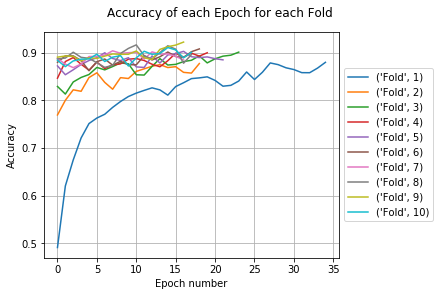

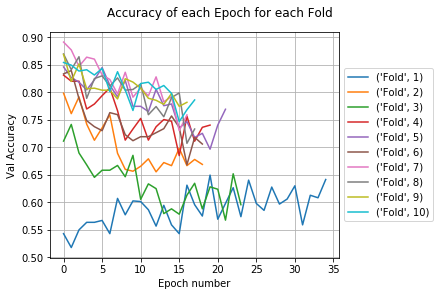

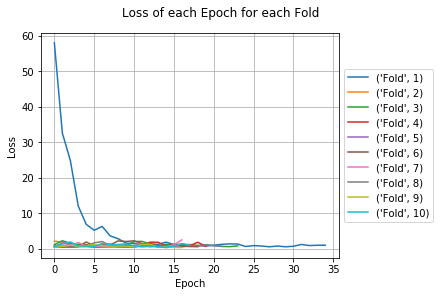

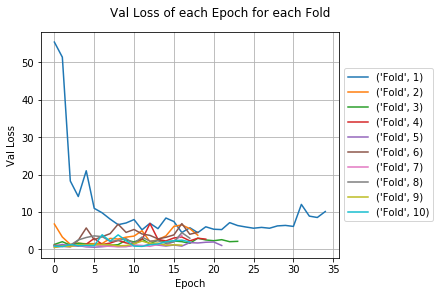

In [30]:
Graph_Epochs_model_2=Graph_func(Epoch_number,Epoch_array_accuracy_2,Val_accuracy_array_2,Loss_array_2,Val_Loss_array_2)

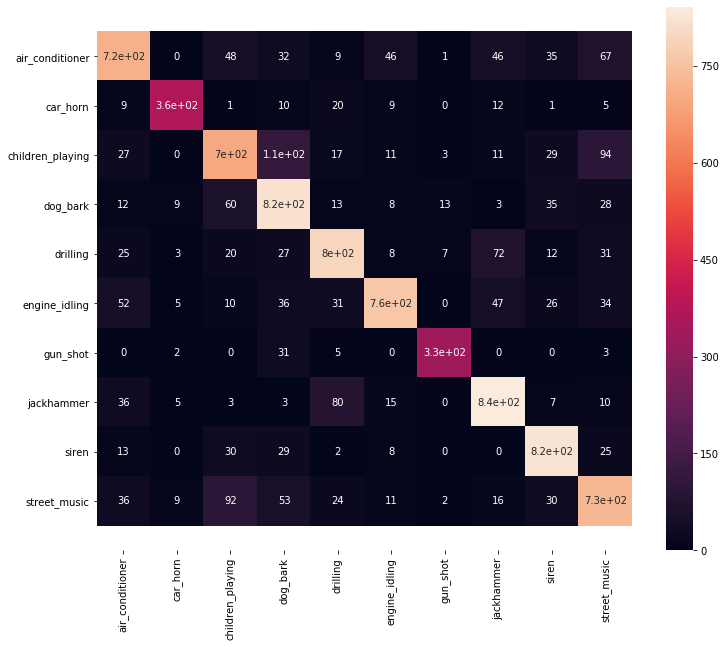

In [31]:
avg_cm = average_confusion_matrix(Confusion_Matrix_array)
plot_confusion_matrix(avg_cm)

In [32]:
Table_model_2=table_maker(Fold_accuracy_2,end_array_2,Avg_Accuracy_2,Time_2)

  Fold  Accuracy  Time Taken
0    1  0.809612     19.3113
1    2  0.845923     10.8682
2    3  0.869353     12.8013
3    4  0.880864     10.1602
4    5  0.883839     12.4917
5    6  0.886472     10.4206
6    7  0.890982      8.1664
7    8  0.892863      9.7280
8    9  0.897103      8.5098
9   10  0.890775      9.6792

    Average Accuracy  Total Time
0          0.874779    112.1367


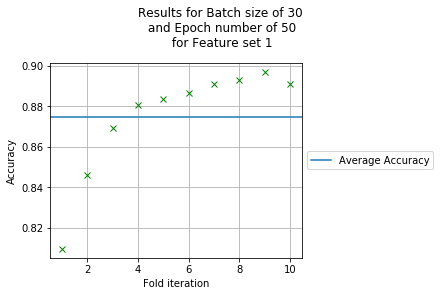

In [33]:
Graph_Avg_model_2=Graph_Avg_maker(Fold_accuracy_2,Avg_Accuracy_2)

### Model 2 no cross validation

In [34]:
for i in range(0, len(X_folds)):
    X_folds[i]=np.reshape(X_folds[i],(X_folds[i].shape[0], 60, 4,1))

Epoch_number=30
X_train = np.vstack([X_folds_10[j] for j in range(0, len(Y_folds_10)-1)])
y_train = np.vstack([Y_folds_10[j] for j in range(0, len(Y_folds_10)-1)])
X_test = X_folds_10[9]
y_test = Y_folds_10[9]

cnn_model_2_history = model_2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=Epoch_number)
score_model_2_no_cross=model_2.evaluate(X_test, y_test)
accuracy_model_2_no_cross = score_model_2_no_cross[1]
print(f"\nAccuracy of model 2 with no cross validation: {round(accuracy_model_2_no_cross,3)}")

Train on 7895 samples, validate on 837 samples
Epoch 1/30
7895/7895 [==============================] - ETA: 0s - loss: 0.6351 - accuracy: 0.87 - ETA: 0s - loss: 1.2898 - accuracy: 0.88 - ETA: 0s - loss: 0.9792 - accuracy: 0.89 - ETA: 0s - loss: 1.0388 - accuracy: 0.89 - ETA: 0s - loss: 1.0451 - accuracy: 0.88 - ETA: 0s - loss: 0.9738 - accuracy: 0.88 - ETA: 0s - loss: 0.9030 - accuracy: 0.88 - ETA: 0s - loss: 0.8435 - accuracy: 0.88 - ETA: 0s - loss: 0.8420 - accuracy: 0.88 - ETA: 0s - loss: 0.8198 - accuracy: 0.88 - ETA: 0s - loss: 0.8210 - accuracy: 0.88 - ETA: 0s - loss: 0.8195 - accuracy: 0.88 - 1s 77us/step - loss: 0.8182 - accuracy: 0.8844 - val_loss: 1.1343 - val_accuracy: 0.8459
Epoch 2/30
7895/7895 [==============================] - ETA: 0s - loss: 2.1965 - accuracy: 0.93 - ETA: 0s - loss: 0.8894 - accuracy: 0.88 - ETA: 0s - loss: 0.6598 - accuracy: 0.89 - ETA: 0s - loss: 0.8135 - accuracy: 0.89 - ETA: 0s - loss: 0.8995 - accuracy: 0.90 - ETA: 0s - loss: 0.8432 - accuracy: 0.8

## Model 3

In [35]:
model_3=Sequential()
early_stopping_cb = EarlyStopping(patience=17, restore_best_weights=True)

model_3.add(Conv2D(32,kernel_size=5,strides=1,padding="Same",activation="relu",input_shape=(60,4,1)))
model_3.add(MaxPooling2D(padding="same"))

model_3.add(Conv2D(64,kernel_size=5,strides=1,padding="same",activation="relu"))
model_3.add(MaxPooling2D(padding="same"))
model_3.add(Dropout(0.2))

model_3.add(Flatten())

model_3.add(Dense(128,activation="relu"))
model_3.add(Dropout(0.2))

model_3.add(Dense(10,activation="softmax"))

    #compiling
Model_3=model_3.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [36]:
accuracy_total_3=0
end_array_3=[]

Epoch_array_accuracy_3=[]
Loss_array_3=[]
Fold_accuracy_3=[]

Val_accuracy_array_3=[]
Val_Loss_array_3=[]

Accuracy_array_3=[]
Avg_Accuracy_3=[]
Time_3=[]

accuracy_score=[]
Epoch_number=50
Batch_size=30

Confusion_Matrix_array = []
Metrics_f1 = []
Metrics_precision = []
Metrics_recall = []
Metrics_accuracy = []

Model_3=Model_run_nn_es(Model_3,model_3,X_folds_10,Y_folds_10,Accuracy_array_3,
                     accuracy_total_3,end_array_3,Epoch_array_accuracy_3,Loss_array_3,
                     Fold_accuracy_3,Val_accuracy_array_3,Val_Loss_array_3, Confusion_Matrix_array,
                     Metrics_f1, Metrics_precision, Metrics_recall, Metrics_accuracy)
Avg_Accuracy_3=Model_3[0]
Time_3=Model_3[1]


Fold #1
- - - - - - - - - - - - - - - - - - - -
(7859, 60, 4, 1) (7859, 10) (873, 60, 4, 1) (873, 10)


C:\Users\tomna\Untitled Folder\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\tomna\Untitled Folder\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy of Fold 1 is 0.5290316939353943
Time to train Fold 1 : 137.7235 seconds.

Fold #2
- - - - - - - - - - - - - - - - - - - -
(7844, 60, 4, 1) (7844, 10) (888, 60, 4, 1) (888, 10)
Accuracy of Fold 2 is 0.6035398840904236
Time to train Fold 2 : 49.0221 seconds.

Fold #3
- - - - - - - - - - - - - - - - - - - -
(7807, 60, 4, 1) (7807, 10) (925, 60, 4, 1) (925, 10)
Accuracy of Fold 3 is 0.6417388916015625
Time to train Fold 3 : 49.3738 seconds.

Fold #4
- - - - - - - - - - - - - - - - - - - -
(7742, 60, 4, 1) (7742, 10) (990, 60, 4, 1) (990, 10)
Accuracy of Fold 4 is 0.6497480869293213
Time to train Fold 4 : 54.041 seconds.

Fold #5
- - - - - - - - - - - - - - - - - - - -
(7796, 60, 4, 1) (7796, 10) (936, 60, 4, 1) (936, 10)
Accuracy of Fold 5 is 0.704020619392395
Time to train Fold 5 : 59.7845 seconds.

Fold #6
- - - - - - - - - - - - - - - - - - - -
(7909, 60, 4, 1) (7909, 10) (823, 60, 4, 1) (823, 10)
Accuracy of Fold 6 is 0.7183002829551697
Time to train Fold 6 : 74.854 seconds.



In [37]:
print('Fold No, F-measure, Precision, Recall, Accuracy')
for i in range(10):
    print(f'{i+1}, {Metrics_f1[i]}, {Metrics_precision[i]}, {Metrics_recall[i]}, {Metrics_accuracy[i]}')
#     print(i + Metrics_f1 + ' , 'Metrics_precision + ' , 'Metrics_recall + ' , 'Metrics_accuracy)

Fold No, F-measure, Precision, Recall, Accuracy
1, 0.5424427317390184, 0.5821691838599145, 0.5544100801832761, 0.5544100801832761
2, 0.703303024764614, 0.7470858003712588, 0.706081081081081, 0.706081081081081
3, 0.6041216947430587, 0.6466164414125848, 0.6086486486486486, 0.6086486486486486
4, 0.7025560778872522, 0.7550398299542366, 0.7111111111111111, 0.7111111111111111
5, 0.695562734703417, 0.7265215271089422, 0.7019230769230769, 0.7019230769230769
6, 0.6611432207907453, 0.6960519606599213, 0.660996354799514, 0.660996354799514
7, 0.7941253368440956, 0.8298585468019692, 0.7911694510739857, 0.7911694510739857
8, 0.7602884777702883, 0.7767665652342601, 0.7679900744416873, 0.7679900744416873
9, 0.7785937031435926, 0.7894520366590811, 0.7879901960784313, 0.7879901960784313
10, 0.7806043964604626, 0.793660801831123, 0.7777777777777778, 0.7777777777777778


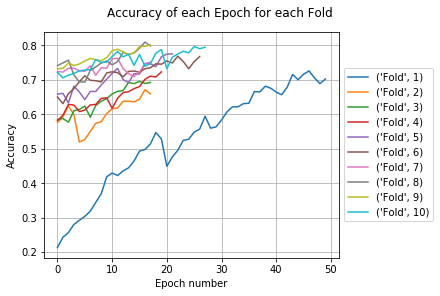

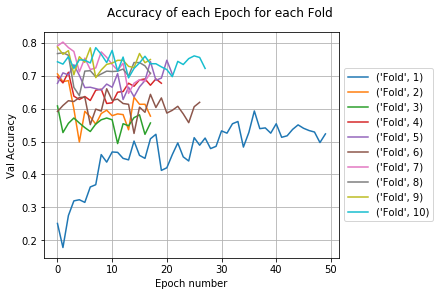

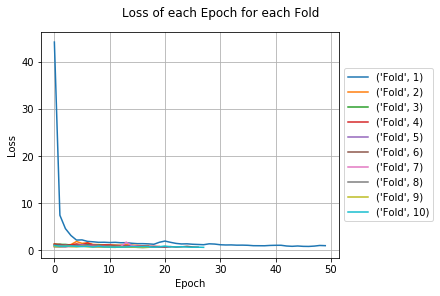

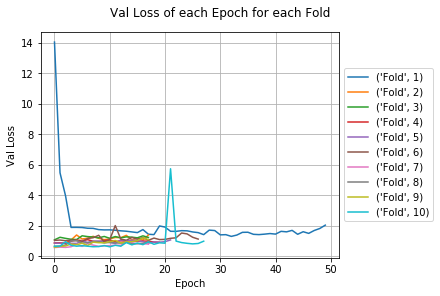

In [38]:
Graph_Epochs_model_3=Graph_func(Epoch_number,Epoch_array_accuracy_3,Val_accuracy_array_3,Loss_array_3,Val_Loss_array_3)

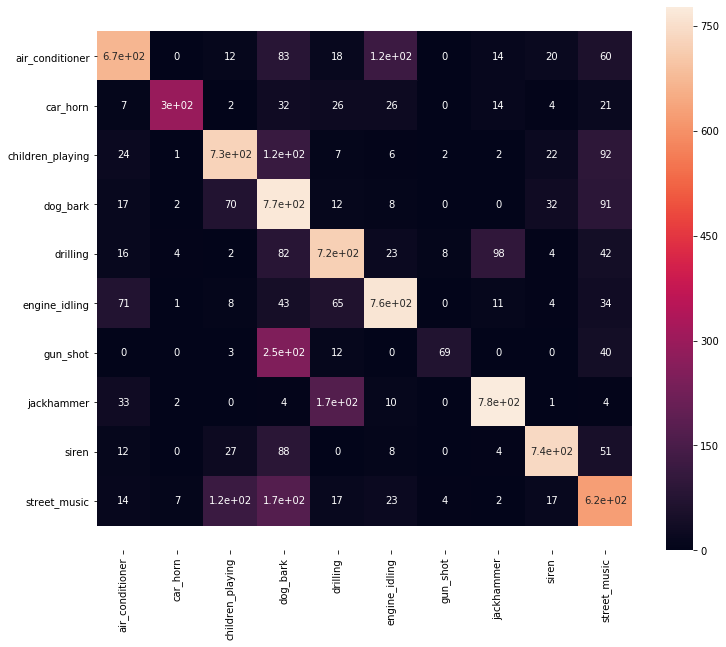

In [39]:
avg_cm = average_confusion_matrix(Confusion_Matrix_array)
plot_confusion_matrix(avg_cm)

In [40]:
Table_model_3=table_maker(Fold_accuracy_3,end_array_3,Avg_Accuracy_3,Time_3)

  Fold  Accuracy  Time Taken
0    1  0.529032    137.7235
1    2  0.603540     49.0221
2    3  0.641739     49.3738
3    4  0.649748     54.0410
4    5  0.704021     59.7845
5    6  0.718300     74.8540
6    7  0.732898     50.1478
7    8  0.752516     51.3007
8    9  0.766542     49.6195
9   10  0.756396     77.2277

    Average Accuracy  Total Time
0          0.685473    653.0946


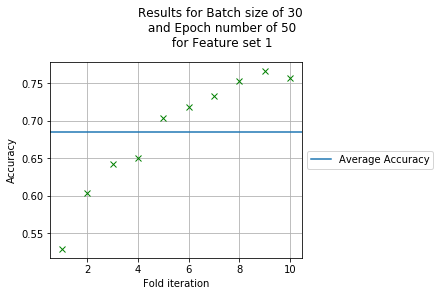

In [41]:
Graph_Avg_model_3=Graph_Avg_maker(Fold_accuracy_3,Avg_Accuracy_3)

### Model 3 no cross validation

In [42]:
X_train = np.vstack([X_folds_10[j] for j in range(0, len(Y_folds_10)-1)])
y_train = np.vstack([Y_folds_10[j] for j in range(0, len(Y_folds_10)-1)])
X_test = X_folds_10[9]
y_test = Y_folds_10[9]

Epoch_number=30
cnn_model_3_history = model_3.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=Epoch_number)
score_model_3_no_cross=model_3.evaluate(X_test, y_test)
accuracy_model_3_no_cross = score_model_3_no_cross[1]
print(f"\nAccuracy of model 3 with no cross validation: {round(accuracy_model_3_no_cross,3)}")

Train on 7895 samples, validate on 837 samples
Epoch 1/30
7895/7895 [==============================] - ETA: 3s - loss: 0.5534 - accuracy: 0.75 - ETA: 2s - loss: 0.5330 - accuracy: 0.80 - ETA: 2s - loss: 0.4965 - accuracy: 0.82 - ETA: 2s - loss: 0.5100 - accuracy: 0.82 - ETA: 2s - loss: 0.5435 - accuracy: 0.82 - ETA: 2s - loss: 0.5598 - accuracy: 0.81 - ETA: 2s - loss: 0.5869 - accuracy: 0.81 - ETA: 2s - loss: 0.5965 - accuracy: 0.80 - ETA: 2s - loss: 0.6072 - accuracy: 0.79 - ETA: 2s - loss: 0.6095 - accuracy: 0.79 - ETA: 2s - loss: 0.6158 - accuracy: 0.79 - ETA: 2s - loss: 0.6397 - accuracy: 0.79 - ETA: 2s - loss: 0.6696 - accuracy: 0.79 - ETA: 2s - loss: 0.6668 - accuracy: 0.79 - ETA: 2s - loss: 0.6699 - accuracy: 0.79 - ETA: 2s - loss: 0.6711 - accuracy: 0.78 - ETA: 2s - loss: 0.6767 - accuracy: 0.78 - ETA: 2s - loss: 0.8755 - accuracy: 0.78 - ETA: 2s - loss: 0.8613 - accuracy: 0.78 - ETA: 2s - loss: 0.8502 - accuracy: 0.78 - ETA: 2s - loss: 0.8445 - accuracy: 0.78 - ETA: 2s - loss:

## Model 4

In [43]:
#adding layers and forming the model_1
#forming model_1
model_4=Sequential()

model_4.add(Conv2D(64,kernel_size=5,strides=1,padding="Same",activation="relu",input_shape=(60,4,1)))
model_4.add(MaxPooling2D(padding="same"))

model_4.add(Flatten())

model_4.add(Dense(10,activation="softmax"))
#compiling
Model_4=model_4.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [44]:
Accuracy_array_4=[]
accuracy_total_4=0
end_array_4=[]

Epoch_array_accuracy_4=[]
Loss_array_4=[]
Fold_accuracy_4=[]

Val_accuracy_array_4=[]
Val_Loss_array_4=[]

Avg_Accuracy_4=[]
Time_4=[]

accuracy_score=[]
Epoch_number=50
Batch_size=30

Confusion_Matrix_array = []
Metrics_f1 = []
Metrics_precision = []
Metrics_recall = []
Metrics_accuracy = []

Model_4=Model_run_nn_es_NO_EARLY_STOPPING(Model_4,model_4,X_folds_10,Y_folds_10,Accuracy_array_4,
                     accuracy_total_4,end_array_4,Epoch_array_accuracy_4,Loss_array_4,
                     Fold_accuracy_4,Val_accuracy_array_4,Val_Loss_array_4, Confusion_Matrix_array,
                     Metrics_f1, Metrics_precision, Metrics_recall, Metrics_accuracy)
Avg_Accuracy_4=Model_4[0]
Time_4=Model_4[1]


Fold #1
- - - - - - - - - - - - - - - - - - - -
(7859, 60, 4, 1) (7859, 10) (873, 60, 4, 1) (873, 10)
Accuracy of Fold 1 is 0.7605522274971008
Time to train Fold 1 : 67.6097 seconds.

Fold #2
- - - - - - - - - - - - - - - - - - - -
(7844, 60, 4, 1) (7844, 10) (888, 60, 4, 1) (888, 10)
Accuracy of Fold 2 is 0.8713921308517456
Time to train Fold 2 : 66.7427 seconds.

Fold #3
- - - - - - - - - - - - - - - - - - - -
(7807, 60, 4, 1) (7807, 10) (925, 60, 4, 1) (925, 10)
Accuracy of Fold 3 is 0.9028230905532837
Time to train Fold 3 : 67.8094 seconds.

Fold #4
- - - - - - - - - - - - - - - - - - - -
(7742, 60, 4, 1) (7742, 10) (990, 60, 4, 1) (990, 10)
Accuracy of Fold 4 is 0.9201447367668152
Time to train Fold 4 : 67.7414 seconds.

Fold #5
- - - - - - - - - - - - - - - - - - - -
(7796, 60, 4, 1) (7796, 10) (936, 60, 4, 1) (936, 10)
Accuracy of Fold 5 is 0.9327962398529053
Time to train Fold 5 : 68.8943 seconds.

Fold #6
- - - - - - - - - - - - - - - - - - - -
(7909, 60, 4, 1) (7909, 10) (82

In [45]:
print('Fold No, F-measure, Precision, Recall, Accuracy')
for i in range(10):
    print(f'{i+1}, {Metrics_f1[i]}, {Metrics_precision[i]}, {Metrics_recall[i]}, {Metrics_accuracy[i]}')
#     print(i + Metrics_f1 + ' , 'Metrics_precision + ' , 'Metrics_recall + ' , 'Metrics_accuracy)

Fold No, F-measure, Precision, Recall, Accuracy
1, 0.46315170500962405, 0.5061076131363226, 0.4822451317296678, 0.4822451317296678
2, 0.6230591033225699, 0.6548801283514047, 0.6295045045045045, 0.6295045045045045
3, 0.6725188681563303, 0.682723821069789, 0.6821621621621622, 0.6821621621621622
4, 0.7029063686562009, 0.7858308346350039, 0.7131313131313132, 0.7131313131313132
5, 0.7890541303328319, 0.8138149918512674, 0.7852564102564102, 0.7852564102564102
6, 0.7916551180394524, 0.8117833898767621, 0.7934386391251519, 0.7934386391251519
7, 0.8945715967247847, 0.9009597356121497, 0.8949880668257757, 0.8949880668257757
8, 0.8253871337430059, 0.8431637262648388, 0.8300248138957816, 0.8300248138957816
9, 0.8982088169840694, 0.9078981740890444, 0.8982843137254902, 0.8982843137254902
10, 0.8888070517368959, 0.9028719084995123, 0.8888888888888888, 0.8888888888888888


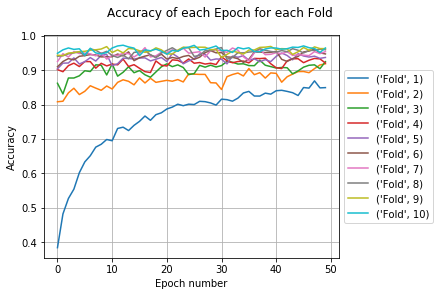

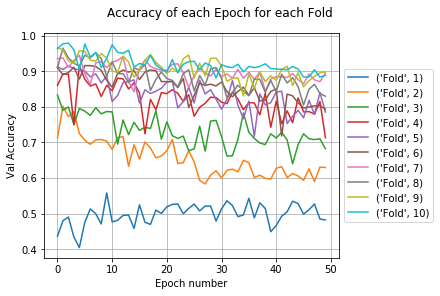

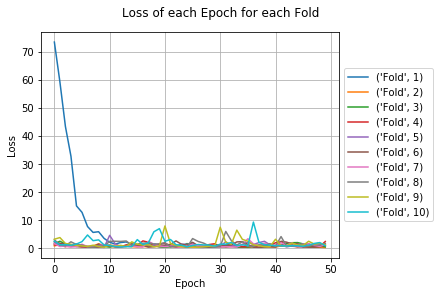

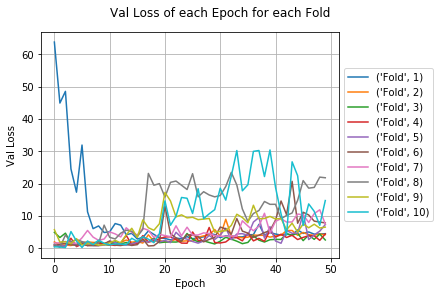

In [46]:
Graph_Epochs_model_4=Graph_func(Epoch_number,Epoch_array_accuracy_4,Val_accuracy_array_4,Loss_array_4,Val_Loss_array_4)

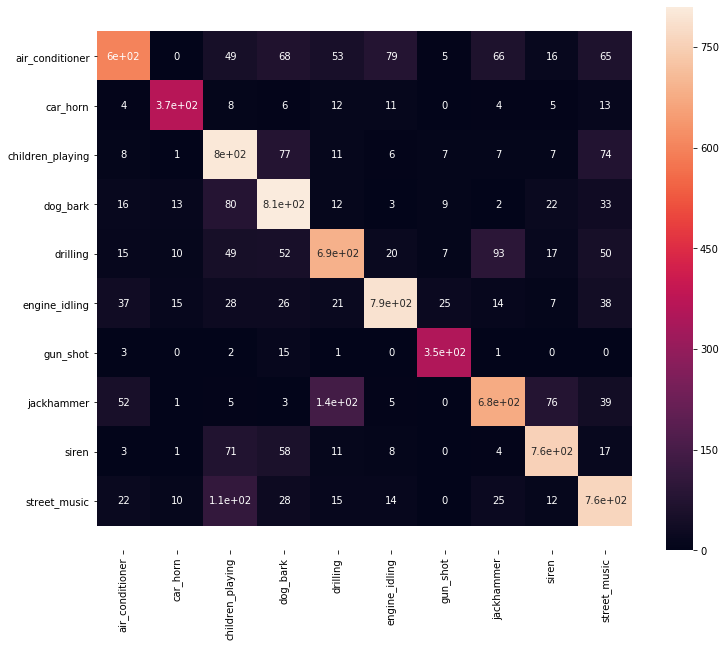

In [47]:
avg_cm = average_confusion_matrix(Confusion_Matrix_array)
plot_confusion_matrix(avg_cm)

In [48]:
Table_model_4=table_maker(Fold_accuracy_4,end_array_4,Avg_Accuracy_4,Time_4)

  Fold  Accuracy  Time Taken
0    1  0.760552     67.6097
1    2  0.871392     66.7427
2    3  0.902823     67.8094
3    4  0.920145     67.7414
4    5  0.932796     68.8943
5    6  0.941080     71.4851
6    7  0.948490     74.6031
7    8  0.952109     73.3700
8    9  0.957582     75.0282
9   10  0.960274     71.1984

    Average Accuracy  Total Time
0          0.914724    704.4823


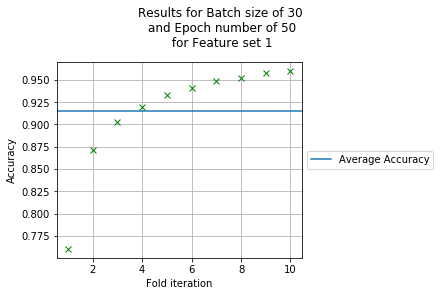

In [49]:
Graph_Avg_model_4=Graph_Avg_maker(Fold_accuracy_4,Avg_Accuracy_4)

In [50]:
X_train = np.vstack([X_folds_10[j] for j in range(0, len(Y_folds_10)-1)])
y_train = np.vstack([Y_folds_10[j] for j in range(0, len(Y_folds_10)-1)])
X_test = X_folds_10[9]
y_test = Y_folds_10[9]

Epoch_number=30
cnn_model_4_history = model_4.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=Epoch_number)
score_model_4_no_cross=model_4.evaluate(X_test, y_test)
accuracy_model_4_no_cross = score_model_4_no_cross[1]
print(f"\nAccuracy of model 4 with no cross validation: {round(accuracy_model_4_no_cross,4)}")

Train on 7895 samples, validate on 837 samples
Epoch 1/30
7895/7895 [==============================] - ETA: 1s - loss: 4.7433e-04 - accuracy: 1.00 - ETA: 1s - loss: 0.2716 - accuracy: 0.9719   - ETA: 1s - loss: 0.5293 - accuracy: 0.96 - ETA: 1s - loss: 0.4757 - accuracy: 0.97 - ETA: 1s - loss: 0.4224 - accuracy: 0.97 - ETA: 1s - loss: 0.4122 - accuracy: 0.96 - ETA: 1s - loss: 0.4222 - accuracy: 0.96 - ETA: 1s - loss: 0.5008 - accuracy: 0.96 - ETA: 1s - loss: 0.5268 - accuracy: 0.96 - ETA: 1s - loss: 1.3380 - accuracy: 0.95 - ETA: 1s - loss: 1.2777 - accuracy: 0.96 - ETA: 1s - loss: 1.2934 - accuracy: 0.96 - ETA: 0s - loss: 1.2887 - accuracy: 0.96 - ETA: 0s - loss: 1.2791 - accuracy: 0.96 - ETA: 0s - loss: 1.5012 - accuracy: 0.96 - ETA: 0s - loss: 1.4098 - accuracy: 0.96 - ETA: 0s - loss: 1.3489 - accuracy: 0.96 - ETA: 0s - loss: 1.3065 - accuracy: 0.96 - ETA: 0s - loss: 1.2463 - accuracy: 0.96 - ETA: 0s - loss: 1.1899 - accuracy: 0.96 - ETA: 0s - loss: 1.3910 - accuracy: 0.96 - ETA: 0s

## Model from Github

In [51]:
# Model from GitHub

#adding layers and forming the model

#forming model
model_5=Sequential()

model_5.add(Conv2D(64,kernel_size=5,strides=1,padding="Same",activation="relu",input_shape=(60,4,1)))
model_5.add(MaxPooling2D(padding="same"))

model_5.add(Conv2D(128,kernel_size=5,strides=1,padding="same",activation="relu"))
model_5.add(MaxPooling2D(padding="same"))
model_5.add(Dropout(0.3))

model_5.add(Flatten())

model_5.add(Dense(256,activation="relu"))
model_5.add(Dropout(0.3))

model_5.add(Dense(512,activation="relu"))
model_5.add(Dropout(0.3))

model_5.add(Dense(10,activation="softmax"))

#compiling
Model_5=model_5.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [52]:
Accuracy_array_5=[]
accuracy_total_5=0
end_array_5=[]

Epoch_array_accuracy_5=[]
Loss_array_5=[]
Fold_accuracy_5=[]

Val_accuracy_array_5=[]
Val_Loss_array_5=[]

Avg_Accuracy_5=[]
Time_5=[]

accuracy_score=[]
Epoch_number=50
Batch_size=30

Confusion_Matrix_array = []
Metrics_f1 = []
Metrics_precision = []
Metrics_recall = []
Metrics_accuracy = []

Model_5=Model_run_nn_es_NO_EARLY_STOPPING(Model_5,model_5,X_folds_10,Y_folds_10,Accuracy_array_5,
                     accuracy_total_5,end_array_5,Epoch_array_accuracy_5,Loss_array_5,
                     Fold_accuracy_5,Val_accuracy_array_5,Val_Loss_array_5, Confusion_Matrix_array,
                     Metrics_f1, Metrics_precision, Metrics_recall, Metrics_accuracy)
Avg_Accuracy_5=Model_5[0]
Time_5=Model_5[1]


Fold #1
- - - - - - - - - - - - - - - - - - - -
(7859, 60, 4, 1) (7859, 10) (873, 60, 4, 1) (873, 10)
Accuracy of Fold 1 is 0.5814352631568909
Time to train Fold 1 : 417.8227 seconds.

Fold #2
- - - - - - - - - - - - - - - - - - - -
(7844, 60, 4, 1) (7844, 10) (888, 60, 4, 1) (888, 10)
Accuracy of Fold 2 is 0.7268230319023132
Time to train Fold 2 : 439.7015 seconds.

Fold #3
- - - - - - - - - - - - - - - - - - - -
(7807, 60, 4, 1) (7807, 10) (925, 60, 4, 1) (925, 10)
Accuracy of Fold 3 is 0.7831202149391174
Time to train Fold 3 : 362.9343 seconds.

Fold #4
- - - - - - - - - - - - - - - - - - - -
(7742, 60, 4, 1) (7742, 10) (990, 60, 4, 1) (990, 10)
Accuracy of Fold 4 is 0.7919323444366455
Time to train Fold 4 : 346.2262 seconds.

Fold #5
- - - - - - - - - - - - - - - - - - - -
(7796, 60, 4, 1) (7796, 10) (936, 60, 4, 1) (936, 10)
Accuracy of Fold 5 is 0.7925295233726501
Time to train Fold 5 : 349.18 seconds.

Fold #6
- - - - - - - - - - - - - - - - - - - -
(7909, 60, 4, 1) (7909, 10) 

In [53]:
print('Fold No, F-measure, Precision, Recall, Accuracy')
for i in range(10):
    print(f'{i+1}, {Metrics_f1[i]}, {Metrics_precision[i]}, {Metrics_recall[i]}, {Metrics_accuracy[i]}')
#     print(i + Metrics_f1 + ' , 'Metrics_precision + ' , 'Metrics_recall + ' , 'Metrics_accuracy)

Fold No, F-measure, Precision, Recall, Accuracy
1, 0.5538415501926912, 0.5747583836378203, 0.5532646048109966, 0.5532646048109966
2, 0.6540915144920993, 0.7031825218251836, 0.6599099099099099, 0.6599099099099099
3, 0.7337093807876282, 0.7639841162373111, 0.7286486486486486, 0.7286486486486486
4, 0.7790141940391471, 0.8021050101606086, 0.7727272727272727, 0.7727272727272727
5, 0.8456945718399408, 0.8647922184509099, 0.842948717948718, 0.842948717948718
6, 0.8027849512676958, 0.8648656983786525, 0.7837181044957473, 0.7837181044957473
7, 0.8068051936328863, 0.8497706986900861, 0.7983293556085919, 0.7983293556085919
8, 0.7755619186614281, 0.8547942440931329, 0.7580645161290323, 0.7580645161290323
9, 0.7779677043877983, 0.8645141181452638, 0.7659313725490197, 0.7659313725490197
10, 0.8631835772603208, 0.9049797994776545, 0.8482676224611708, 0.8482676224611708


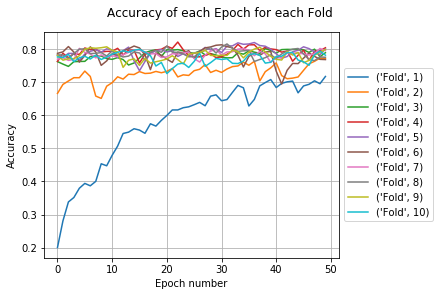

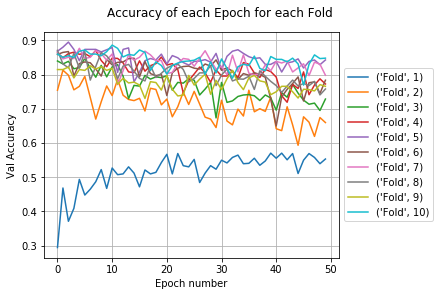

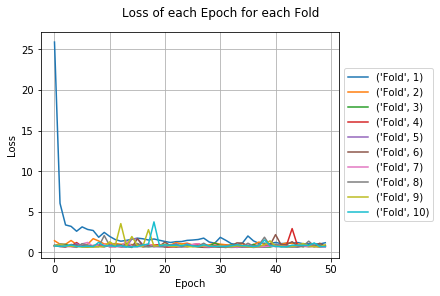

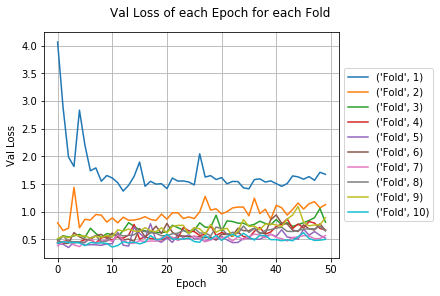

In [54]:
Graph_Epochs_model_5=Graph_func(Epoch_number,Epoch_array_accuracy_5,Val_accuracy_array_5,Loss_array_5,Val_Loss_array_5) 

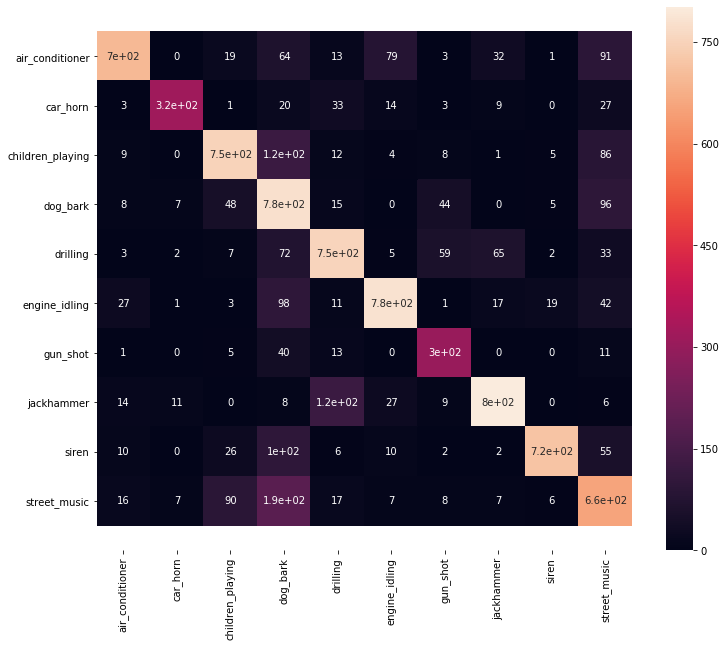

In [55]:
avg_cm = average_confusion_matrix(Confusion_Matrix_array)
plot_confusion_matrix(avg_cm)

In [56]:
Table_model_5=table_maker(Fold_accuracy_5,end_array_5,Avg_Accuracy_5,Time_5)

  Fold  Accuracy  Time Taken
0    1  0.581435    417.8227
1    2  0.726823    439.7015
2    3  0.783120    362.9343
3    4  0.791932    346.2262
4    5  0.792530    349.1800
5    6  0.781090    351.8192
6    7  0.785110    348.6708
7    8  0.787585    407.5240
8    9  0.781448    446.5665
9   10  0.772423    442.5571

    Average Accuracy  Total Time
0           0.75835   3913.0023


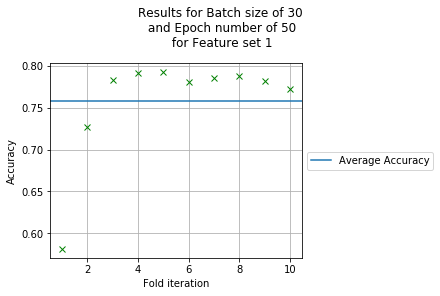

In [57]:
Graph_Avg_model_5=Graph_Avg_maker(Fold_accuracy_5,Avg_Accuracy_5)

### Github model with no cross validation

In [58]:
X_train = np.vstack([X_folds_10[j] for j in range(0, len(Y_folds_10)-1)])
y_train = np.vstack([Y_folds_10[j] for j in range(0, len(Y_folds_10)-1)])
X_test = X_folds_10[9]
y_test = Y_folds_10[9]

Epoch_number=30
cnn_model_5_history = model_5.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=Epoch_number)
score_model_5_no_cross=model_5.evaluate(X_test, y_test)
accuracy_model_5_no_cross = score_model_5_no_cross[1]
print(f"\nAccuracy of model 5 with no cross validation: {round(accuracy_model_5_no_cross,4)}")

Train on 7895 samples, validate on 837 samples
Epoch 1/30
7895/7895 [==============================] - ETA: 9s - loss: 0.4697 - accuracy: 0.84 - ETA: 10s - loss: 0.5350 - accuracy: 0.822 - ETA: 10s - loss: 0.5251 - accuracy: 0.828 - ETA: 10s - loss: 0.5848 - accuracy: 0.817 - ETA: 10s - loss: 0.6096 - accuracy: 0.804 - ETA: 10s - loss: 0.5853 - accuracy: 0.815 - ETA: 10s - loss: 0.6026 - accuracy: 0.809 - ETA: 10s - loss: 0.7597 - accuracy: 0.805 - ETA: 10s - loss: 0.7631 - accuracy: 0.795 - ETA: 10s - loss: 0.7483 - accuracy: 0.798 - ETA: 10s - loss: 0.7557 - accuracy: 0.799 - ETA: 10s - loss: 0.7324 - accuracy: 0.801 - ETA: 10s - loss: 0.7097 - accuracy: 0.807 - ETA: 10s - loss: 0.6984 - accuracy: 0.808 - ETA: 10s - loss: 0.7160 - accuracy: 0.804 - ETA: 10s - loss: 0.7028 - accuracy: 0.806 - ETA: 10s - loss: 0.6956 - accuracy: 0.804 - ETA: 9s - loss: 0.7181 - accuracy: 0.790 - ETA: 9s - loss: 0.7037 - accuracy: 0.79 - ETA: 9s - loss: 0.7059 - accuracy: 0.79 - ETA: 9s - loss: 0.7083 -

### Model comparisson

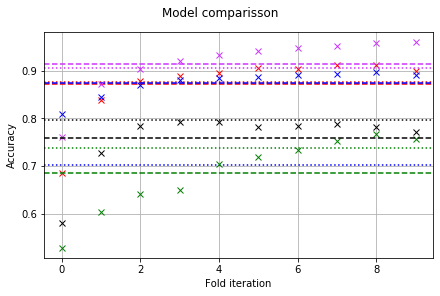

In [59]:
%matplotlib inline

 

fig, ax1 = plt.subplots(1, 1, constrained_layout=True, subplot_kw=dict())

 

ax1.plot(Fold_accuracy,"rx",label="Model 1")
ax1.axhline(y=Avg_Accuracy,label='Average Accuracy Model 1',color='r',ls="--")
ax1.axhline(y=accuracy_model_1_no_cross,label='Accuracy Model 1 no cross validation',color='r',ls=":")

 


ax1.plot(Fold_accuracy_2,"bx",label="Model 2")
ax1.axhline(y=Avg_Accuracy_2,label='Average Accuracy Model 2',color='b',ls="--")
ax1.axhline(y=accuracy_model_2_no_cross,label='Accuracy Model 2 no cross validation',color='b',ls=":")

 


ax1.plot(Fold_accuracy_3,"gx",label="Model 3")
ax1.axhline(y=Avg_Accuracy_3,label='Average Accuracy Model 3',color='g',ls="--")
ax1.axhline(y=accuracy_model_3_no_cross,label='Accuracy Model 3 no cross validation',color='g',ls=":")

 

ax1.plot(Fold_accuracy_4,"x", color="#cc33ff",label="Model 4")
ax1.axhline(y=Avg_Accuracy_4,label='Average Accuracy Model 4',color='#cc33ff',ls="--")
ax1.axhline(y=accuracy_model_4_no_cross,label='Accuracy Model 4 no cross validation',color='#cc33ff',ls=":")

 

ax1.plot(Fold_accuracy_5,"kx",label="Model 5")
ax1.axhline(y=Avg_Accuracy_5,label='Average Accuracy Model 5',color='k',ls="--")
ax1.axhline(y=accuracy_model_5_no_cross,label='Accuracy Model 5 no cross validation',color='k',ls=":")

 

#ax1.set_title('Results for a batch size of',Batch_size,'and',Epoch_number,'.')
fig.suptitle(f"Model comparisson")
ax1.set_xlabel("Fold iteration")
ax1.set_ylabel("Accuracy")
ax1.grid()
#ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## Logistic Regression

In [60]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

X_folds, Y_folds = data_processor_log_reg(X_folds,Y_folds)

X_train = np.vstack([X_folds[j] for j in range(0, len(Y_folds)-1)])
y_train = np.vstack([Y_folds[j] for j in range(0, len(Y_folds)-1)])
X_test = X_folds[9]
y_test = Y_folds[9]

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

C:\Users\tomna\Untitled Folder\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\tomna\Untitled Folder\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\tomna\Untitled Folder\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\tomna\Untitled Folder\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Accuracy of logistic regression classifier on test set: 0.49


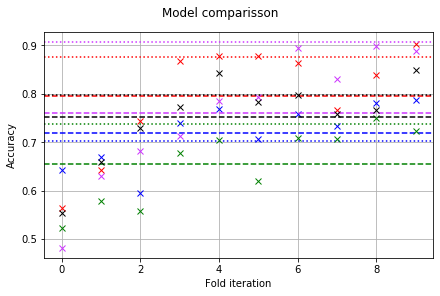

In [61]:
Val_accuracy_array_fix = [Val_accuracy_array[i][-1] for i in range(10)]
Val_accuracy_array_2_fix = [Val_accuracy_array_2[i][-1] for i in range(10)]
Val_accuracy_array_3_fix = [Val_accuracy_array_3[i][-1] for i in range(10)]
Val_accuracy_array_4_fix = [Val_accuracy_array_4[i][-1] for i in range(10)]
Val_accuracy_array_5_fix = [Val_accuracy_array_5[i][-1] for i in range(10)]

 

%matplotlib inline

 

fig, ax1 = plt.subplots(1, 1, constrained_layout=True, subplot_kw=dict())

 

ax1.plot(Val_accuracy_array_fix,"rx",label="Model 1")
ax1.axhline(y=np.average(Val_accuracy_array_fix),label='Average Accuracy Model 1',color='r',ls="--")
ax1.axhline(y=accuracy_model_1_no_cross,label='Accuracy Model 1 no cross validation',color='r',ls=":")

 


ax1.plot(Val_accuracy_array_2_fix,"bx",label="Model 2")
ax1.axhline(y=np.average(Val_accuracy_array_2_fix),label='Average Accuracy Model 2',color='b',ls="--")
ax1.axhline(y=accuracy_model_2_no_cross,label='Accuracy Model 2 no cross validation',color='b',ls=":")

 


ax1.plot(Val_accuracy_array_3_fix,"gx",label="Model 3")
ax1.axhline(y=np.average(Val_accuracy_array_3_fix),label='Average Accuracy Model 3',color='g',ls="--")
ax1.axhline(y=accuracy_model_3_no_cross,label='Accuracy Model 3 no cross validation',color='g',ls=":")

 

ax1.plot(Val_accuracy_array_4_fix,"x", color="#cc33ff",label="Model 4")
ax1.axhline(y=np.average(Val_accuracy_array_4_fix),label='Average Accuracy Model 4',color='#cc33ff',ls="--")
ax1.axhline(y=accuracy_model_4_no_cross,label='Accuracy Model 4 no cross validation',color='#cc33ff',ls=":")

 

ax1.plot(Val_accuracy_array_5_fix,"kx",label="Model 5")
ax1.axhline(y=np.average(Val_accuracy_array_5_fix),label='Average Accuracy Model 5',color='k',ls="--")
ax1.axhline(y=accuracy_model_5_no_cross,label='Accuracy Model 5 no cross validation',color='k',ls=":")

 

#ax1.set_title('Results for a batch size of',Batch_size,'and',Epoch_number,'.')
fig.suptitle(f"Model comparisson")
ax1.set_xlabel("Fold iteration")
ax1.set_ylabel("Accuracy")
ax1.grid()
#ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))